In [3]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [47]:
print(1e-4)

0.0001


5e-06


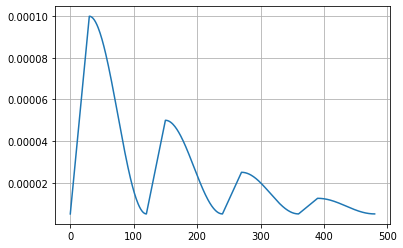

In [48]:
from torch.optim import SGD, AdamW, RMSprop
import torch.nn as nn

lr = 5e-6
epochs = 15
# warmup_epoch = 5
# warmup_lr = 4e-3

model = nn.Conv2d(3, 16, 3)
# optimizer = optim.Adam(model.parameters(), lr = 0)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=epochs*32//4, T_mult=1, eta_max=1e-4,  T_up=30, gamma=0.5)

lr_list = [lr]
# warmup_iter = warmup_epoch * 32

# lr_lambda = lambda e: (e * (lr - warmup_lr) / warmup_iter + warmup_lr) / lr
# warmup_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = SequentialLR(optimizer, [warmup_scheduler, main_scheduler], [warmup_iter])

for i in range(epochs):
    for j in range(32):
        optimizer.step()
        temp = optimizer.state_dict()
        scheduler.step()
        lr_list.append(scheduler.get_lr()[0])
        # temp = optimizer.state_dict()
        # lr_list.append(temp['param_groups'][0]['lr'])
        # scheduler.step()
        # lr_list.append(scheduler.get_last_lr())
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(lr_list)
print(lr_list[-1])

[0.0001]


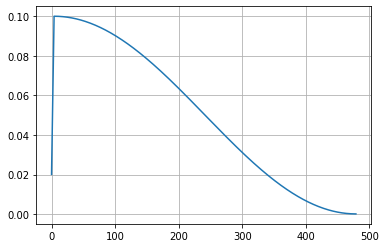

In [5]:
from torch.optim import SGD, AdamW, RMSprop
import torch.nn as nn

lr = 0.0001
epochs = 15
cos_iter = 1
# warmup_epoch = 5
# warmup_lr = 4e-3

model = nn.Conv2d(3, 16, 3)
# optimizer = optim.Adam(model.parameters(), lr = 0)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=epochs*32//cos_iter, T_mult=1, eta_max=0.1,  T_up=5, gamma=0.2)

lr_list = []
# warmup_iter = warmup_epoch * 32

# lr_lambda = lambda e: (e * (lr - warmup_lr) / warmup_iter + warmup_lr) / lr
# warmup_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = SequentialLR(optimizer, [warmup_scheduler, main_scheduler], [warmup_iter])

for i in range(epochs):
    for j in range(32):
        optimizer.step()
        temp = optimizer.state_dict()
        scheduler.step()
        lr_list.append(scheduler.get_lr())
        # temp = optimizer.state_dict()
        # lr_list.append(temp['param_groups'][0]['lr'])
        # scheduler.step()
        # lr_list.append(scheduler.get_last_lr())
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(lr_list)
print(lr_list[-1])

In [30]:
from torch.optim import SGD, AdamW, RMSprop
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

lr = 0.0001
epochs = 15
cos_iter = 4
# warmup_epoch = 5
# warmup_lr = 4e-3

model = nn.Conv2d(3, 16, 3)
# optimizer = optim.Adam(model.parameters(), lr = 0)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs*32//cos_iter, eta_min=0.00001)

lr_list = [lr]
# lr_list.append()
# warmup_iter = warmup_epoch * 32

# lr_lambda = lambda e: (e * (lr - warmup_lr) / warmup_iter + warmup_lr) / lr
# warmup_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = SequentialLR(optimizer, [warmup_scheduler, main_scheduler], [warmup_iter])

for i in range(epochs):
    for j in range(32):
        optimizer.step()
        temp = optimizer.state_dict()
        scheduler.step()
        lr_list.append(scheduler.get_last_lr()[0])
        # temp = optimizer.state_dict()
        # lr_list.append(temp['param_groups'][0]['lr'])
        # scheduler.step()
        # lr_list.append(scheduler.get_last_lr())
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(lr_list)
print(lr_list[-1])

KeyError: ignored

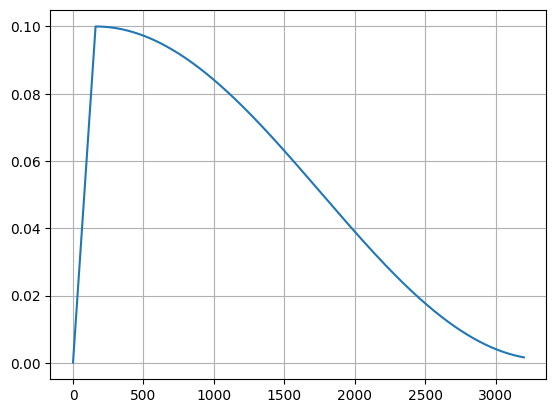

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR, StepLR, ExponentialLR, LambdaLR, SequentialLR
from torch.optim import SGD, AdamW, RMSprop
from timm import create_model

lr = 0.1
epochs = 100
warmup_epoch = 5
warmup_lr = 1e-4

model = create_model("resnet50")
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
main_scheduler = CosineAnnealingLR(optimizer, T_max=epochs*32, eta_min=0.001)

lr_list = []
warmup_iter = warmup_epoch * 32

lr_lambda = lambda e: (e * (lr - warmup_lr) / warmup_iter + warmup_lr) / lr
warmup_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scheduler = SequentialLR(optimizer, [warmup_scheduler, main_scheduler], [warmup_iter])

for i in range(epochs):
    for j in range(32):
        temp = optimizer.state_dict()
        lr_list.append(temp['param_groups'][0]['lr'])
        scheduler.step()

import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(lr_list)

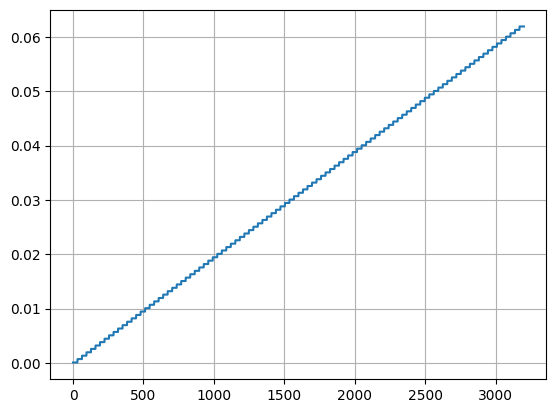

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR, StepLR, ExponentialLR, LambdaLR, SequentialLR
from torch.optim import SGD, AdamW, RMSprop
from timm import create_model

lr = 0.1
epochs = 100
warmup_epoch = 5
warmup_lr = 1e-4

model = create_model("resnet50")
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
main_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=0.001)

lr_list = []
warmup_iter = warmup_epoch * 32

lr_lambda = lambda e: (e * (lr - warmup_lr) / warmup_iter + warmup_lr) / lr
warmup_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scheduler = SequentialLR(optimizer, [warmup_scheduler, main_scheduler], [warmup_iter])

for i in range(epochs):
    for j in range(32):
        temp = optimizer.state_dict()
        lr_list.append(temp['param_groups'][0]['lr'])
    scheduler.step()

import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(lr_list, )